# **Import libraries**

In [2]:
!git clone https://github.com/raphaelvallat/pingouin.git

Cloning into 'pingouin'...
remote: Enumerating objects: 13110, done.
remote: Counting objects: 100% (1297/1297), done.
remote: Compressing objects: 100% (441/441), done.
remote: Total 13110 (delta 961), reused 1083 (delta 846), pack-reused 11813
Receiving objects: 100% (13110/13110), 14.43 MiB | 22.87 MiB/s, done.
Resolving deltas: 100% (10438/10438), done.


In [3]:
%cd pingouin

/content/pingouin


In [4]:
!pip install .

Processing /content/pingouin
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pingouin: filename=pingouin-0.5.4-py3-none-any.whl size=204194 sha256=8645c3841d6a00f28d1950690abfa94de334ba0749184a3c044300a5a9a378f6
  Stored in directory: /tmp/pip-ephem-wheel-cache-4ak0sah8/wheels/a6/54/3b/73cf1e6d1eb68d11d102cbc9a71c114b4fd97d0651dbb1a1e9
Successfully built pingouin


In [5]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os

import pingouin as pg
import scipy.stats as stats
import statsmodels.stats.api as sms
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import ttest_ind
from scipy.stats import shapiro
from math import ceil

# **Bring the data**

In [6]:
from google.colab import drive
drive.mount('/content/drive')

data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/assessment_da25.csv')

Mounted at /content/drive


In [7]:
data

,Variant,Number of page views,GMV (in $),Number of add to cart,Clicks on media,Time on Page (sec),user_id
0,A,5,0.00,0,2,74,0
1,A,4,0.00,4,1,21,1
2,A,4,0.00,2,0,1,2
3,A,5,0.00,0,1,26,3
4,A,5,0.00,3,3,46,4
...,...,...,...,...,...,...,...
1995,B,3,0.00,1,0,1,1995
1996,B,3,0.00,1,2,31,1996
1997,B,3,0.00,2,0,3,1997
1998,B,4,87.08,2,1,11,1998


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Variant                2000 non-null   object 
 1   Number of page views   2000 non-null   int64  
 2   GMV (in $)             2000 non-null   float64
 3   Number of add to cart  2000 non-null   int64  
 4   Clicks on media        2000 non-null   int64  
 5   Time on Page (sec)     2000 non-null   int64  
 6   user_id                2000 non-null   int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 109.5+ KB


# **Sanity check**

Checking the number of users in both group and see if sample ratio mismatch(SRM) is happened

In [9]:
# Calculate the unique IDs per variant
data.groupby('Variant')['user_id'].nunique()

# Assign the unique counts to each variant
control_users = data[data['Variant']=='A']['user_id'].nunique()
exposed_users = data[data['Variant']=='B']['user_id'].nunique()
total_users = control_users + exposed_users

# Calculate allocation ratios per variant
control_perc = control_users / total_users
exposed_perc = exposed_users / total_users
print("Percentage of users in the control group: ", 100*round(control_perc,5), "%")
print("Percentage of users in the exposed group: ", 100*round(exposed_perc,5), "%")

Percentage of users in the control group:  50.0 %
Percentage of users in the exposed group:  50.0 %


In [10]:
# Create lists of observed and expected counts per variant
observed = [control_users, exposed_users]
expected = [total_users/2, total_users/2]

# Import chisquare from scipy library
from scipy.stats import chisquare

# Run chisquare test on observed and expected lists
chi = chisquare(observed, f_exp=expected)

# Print test results and interpretation
print(chi)
if chi[1] > 0.01 :
	print("SRM may be present")
else:
	print("SRM likely not present")

Power_divergenceResult(statistic=0.0, pvalue=1.0)
SRM may be present


# **Analyzing difference**

# 1. **Number of page views**

In [11]:
# 1. Number of page views

# Check the mean of Number of page views by group
data.groupby('Variant')['Number of page views'].agg(["count", "median", "mean", "std", "min", "max"])

,count,median,mean,std,min,max
Variant,,,,,,
A,1000,5.0,4.985,2.236465,0,12
B,1000,5.0,5.317,2.417096,0,15


<ipython-input-12-2e0859cb8706>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data, x='Number of page views', y='Variant', inner='box', palette='Set2')


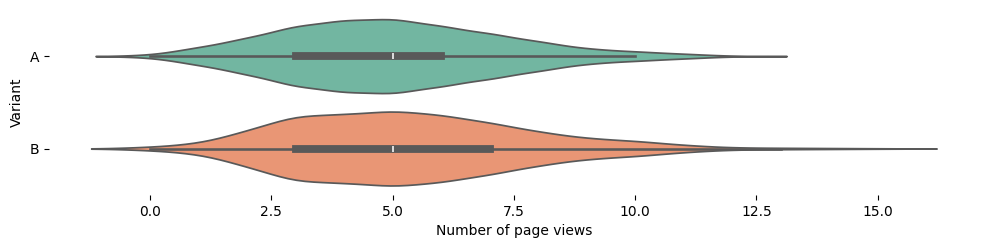

In [12]:
# Make violin plot
figsize = (12, 1.2 * len(data['Variant'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(data, x='Number of page views', y='Variant', inner='box', palette='Set2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [13]:
# Assuming 'Variant' column contains control and treatment groups
control_group = data[data['Variant'] == 'A']
treatment_group = data[data['Variant'] == 'B']

# Calculate the mean of the number of page views for both groups
mean_pv_control = control_group['Number of page views'].mean()
mean_pv_treatment = treatment_group['Number of page views'].mean()

# Calculate the difference in mean of the number of page views
mean_pv_difference = mean_pv_treatment - mean_pv_control

# Perform a two-sample t-test
t_stat, p_value = ttest_ind(control_group['Number of page views'], treatment_group['Number of page views'], equal_var=False, nan_policy='omit')

# Assume a significance level
alpha = 0.05

# Print results
print(f"Mean of the number of page views (Control): {mean_pv_control}")
print(f"Mean of the number of page views (Treatment): {mean_pv_treatment}")
print(f"Difference in Mean of the number of page views: {mean_pv_difference}")
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

if p_value < alpha:
    print("Null hypothesis rejected. There is a statistically significant difference between groups.")
else:
    print("Null hypothesis not rejected. There is no statistically significant difference between groups.")

Mean of the number of page views (Control): 4.985
Mean of the number of page views (Treatment): 5.317
Difference in Mean of the number of page views: 0.33199999999999985
T-statistic: -3.1881645133877003
P-value: 0.001454076157215842
Null hypothesis rejected. There is a statistically significant difference between groups.


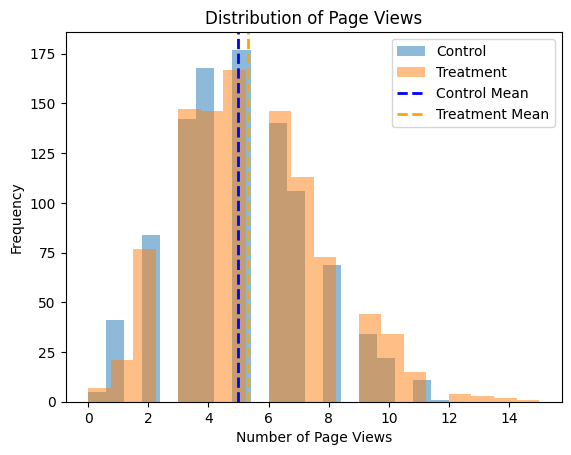

In [14]:
# Plot histograms
plt.hist(control_group['Number of page views'], bins=20, alpha=0.5, label='Control')
plt.hist(treatment_group['Number of page views'], bins=20, alpha=0.5, label='Treatment')

# Add a line graph for mean
plt.axvline(control_group['Number of page views'].mean(), color='blue', linestyle='dashed', linewidth=2, label='Control Mean')
plt.axvline(treatment_group['Number of page views'].mean(), color='orange', linestyle='dashed', linewidth=2, label='Treatment Mean')

plt.xlabel('Number of Page Views')
plt.ylabel('Frequency')
plt.title('Distribution of Page Views')

plt.legend()

plt.show()

# **2. Number of add to cart**

In [15]:
# 2. Number of add to cart

# Check the mean of Number of add to cart by group
data.groupby('Variant')['Number of add to cart'].agg(["count", "median", "mean", "std", "min", "max"])

,count,median,mean,std,min,max
Variant,,,,,,
A,1000,2.0,1.884,1.297778,0,8
B,1000,2.0,2.469,1.660662,0,10


<ipython-input-16-1a47fe30a362>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data, x='Number of add to cart', y='Variant', inner='box', palette='Set2')


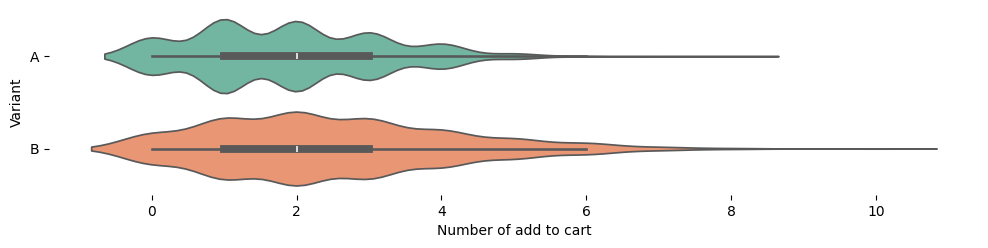

In [16]:
# Make violin plot
figsize = (12, 1.2 * len(data['Variant'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(data, x='Number of add to cart', y='Variant', inner='box', palette='Set2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [17]:
# Assuming 'Variant' column contains control and treatment groups
control_group = data[data['Variant'] == 'A']
treatment_group = data[data['Variant'] == 'B']

# Calculate the mean of the number of add to cart for both groups
mean_ac_control = control_group['Number of add to cart'].mean()
mean_ac_treatment = treatment_group['Number of add to cart'].mean()

# Calculate the difference in mean of the number of add to cart
mean_ac_difference = mean_ac_treatment - mean_ac_control

# Perform a two-sample t-test
t_stat, p_value = ttest_ind(control_group['Number of add to cart'], treatment_group['Number of add to cart'], equal_var=False, nan_policy='omit')

# Assume a significance level
alpha = 0.05

# Print results
print(f"Mean of the number of add to cart (Control): {mean_ac_control}")
print(f"Mean of the number of add to cart (Treatment): {mean_ac_treatment}")
print(f"Difference in Mean of the number of add to cart: {mean_ac_difference}")
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

if p_value < alpha:
    print("Null hypothesis rejected. There is a statistically significant difference between groups.")
else:
    print("Null hypothesis not rejected. There is no statistically significant difference between groups.")

Mean of the number of add to cart (Control): 1.884
Mean of the number of add to cart (Treatment): 2.469
Difference in Mean of the number of add to cart: 0.585
T-statistic: -8.777389396187948
P-value: 3.668898697938531e-18
Null hypothesis rejected. There is a statistically significant difference between groups.


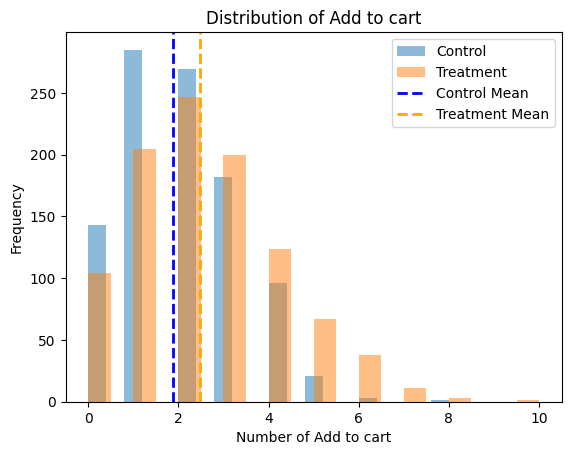

In [18]:
# Plot histograms for control and treatment groups
plt.hist(control_group['Number of add to cart'], bins=20, alpha=0.5, label='Control')
plt.hist(treatment_group['Number of add to cart'], bins=20, alpha=0.5, label='Treatment')

# Add a line graph for mean
plt.axvline(control_group['Number of add to cart'].mean(), color='blue', linestyle='dashed', linewidth=2, label='Control Mean')
plt.axvline(treatment_group['Number of add to cart'].mean(), color='orange', linestyle='dashed', linewidth=2, label='Treatment Mean')

plt.xlabel('Number of Add to cart')
plt.ylabel('Frequency')
plt.title('Distribution of Add to cart')

plt.legend()

plt.show()

# **3. Clicks on media**

In [19]:
# 3. Clicks on media

# Check the mean of Clicks on media by group
data.groupby('Variant')['Clicks on media'].agg(["count", "median", "mean", "std", "min", "max"])

,count,median,mean,std,min,max
Variant,,,,,,
A,1000,1.0,1.495,1.230239,0,6
B,1000,1.0,1.324,1.180855,0,7


<ipython-input-20-e71cfc79afbc>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data, x='Clicks on media', y='Variant', inner='box', palette='Set2')


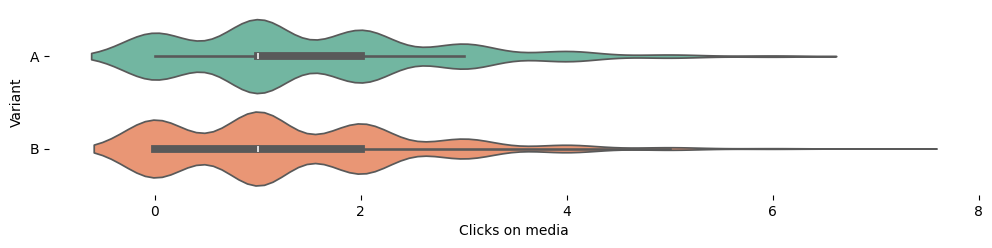

In [20]:
figsize = (12, 1.2 * len(data['Variant'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(data, x='Clicks on media', y='Variant', inner='box', palette='Set2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [21]:
# Assuming 'Variant' column contains control and treatment groups
control_group = data[data['Variant'] == 'A']
treatment_group = data[data['Variant'] == 'B']

# Calculate the mean of clicks on media for both groups
mean_clicks_control = control_group['Clicks on media'].mean()
mean_clicks_treatment = treatment_group['Clicks on media'].mean()

# Calculate the difference in mean of clicks on media
mean_clicks_difference = mean_clicks_treatment - mean_clicks_control

# Perform a two-sample t-test
t_stat, p_value = ttest_ind(control_group['Clicks on media'], treatment_group['Clicks on media'], equal_var=False, nan_policy='omit')

# Assume a significance level
alpha = 0.05

# Print results
print(f"Mean of clicks on media (Control): {mean_clicks_control}")
print(f"Mean of clicks on media (Treatment): {mean_clicks_treatment}")
print(f"Difference in Mean of clicks on media: {mean_clicks_difference}")
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

if p_value < alpha:
    print("Null hypothesis rejected. There is a statistically significant difference between groups.")
else:
    print("Null hypothesis not rejected. There is no statistically significant difference between groups.")

Mean of clicks on media (Control): 1.495
Mean of clicks on media (Treatment): 1.324
Difference in Mean of clicks on media: -0.17100000000000004
T-statistic: 3.1710702328903153
P-value: 0.001541857715988478
Null hypothesis rejected. There is a statistically significant difference between groups.


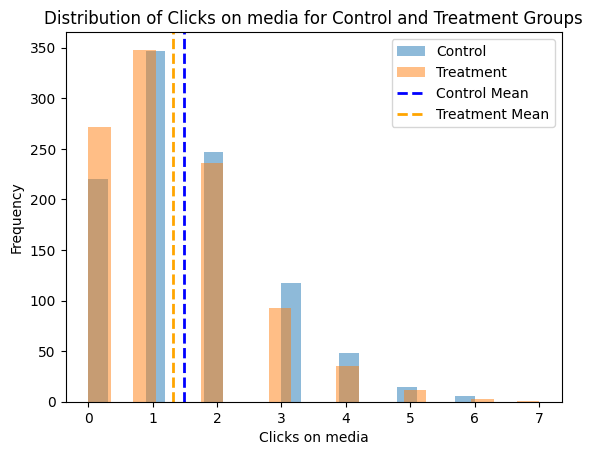

In [22]:
import matplotlib.pyplot as plt

# Plot histograms for control and treatment groups
plt.hist(control_group['Clicks on media'], bins=20, alpha=0.5, label='Control')
plt.hist(treatment_group['Clicks on media'], bins=20, alpha=0.5, label='Treatment')

# Add a line graph for mean
plt.axvline(control_group['Clicks on media'].mean(), color='blue', linestyle='dashed', linewidth=2, label='Control Mean')
plt.axvline(treatment_group['Clicks on media'].mean(), color='orange', linestyle='dashed', linewidth=2, label='Treatment Mean')

plt.xlabel('Clicks on media')
plt.ylabel('Frequency')
plt.title('Distribution of Clicks on media for Control and Treatment Groups')

plt.legend()

plt.show()

# **4. Time on Page (sec)**

In [23]:
# 4. Time on Page (sec)

# Check the mean of the time on page by group
data.groupby('Variant')['Time on Page (sec)'].agg(["count", "median", "mean", "std", "min", "max"])

,count,median,mean,std,min,max
Variant,,,,,,
A,1000,13.0,20.543,20.596076,1,143
B,1000,14.0,20.047,19.319784,1,132


<ipython-input-24-2aa8e3db35e2>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data, x='Time on Page (sec)', y='Variant', inner='box', palette='Set2')


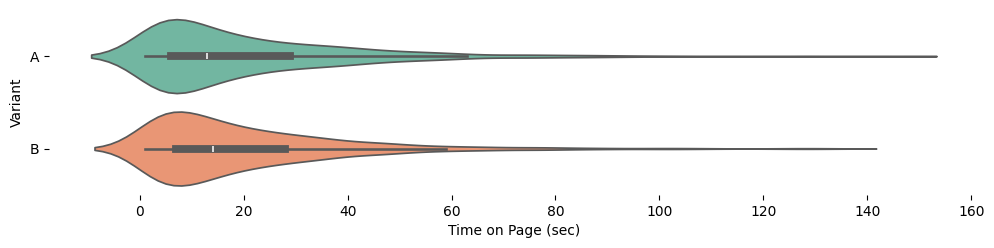

In [24]:
figsize = (12, 1.2 * len(data['Variant'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(data, x='Time on Page (sec)', y='Variant', inner='box', palette='Set2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [25]:
# Assuming 'Variant' column contains control and treatment groups
control_group = data[data['Variant'] == 'A']
treatment_group = data[data['Variant'] == 'B']

# Calculate the mean of the time on page for both groups
mean_tp_control = control_group['Time on Page (sec)'].mean()
mean_tp_treatment = treatment_group['Time on Page (sec)'].mean()

# Calculate the difference in mean the time on page
mean_tp_difference = mean_tp_treatment - mean_tp_control

# Perform a two-sample t-test
t_stat, p_value = ttest_ind(control_group['Time on Page (sec)'], treatment_group['Time on Page (sec)'], equal_var=False, nan_policy='omit')

# Assume a significance level
alpha = 0.05

# Print results
print(f"Mean of the time on page (Control): {mean_tp_control}")
print(f"Mean of the time on page (Treatment): {mean_tp_treatment}")
print(f"Difference in Mean of the time on page: {mean_tp_difference}")
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

if p_value < alpha:
    print("Null hypothesis rejected. There is a statistically significant difference between groups.")
else:
    print("Null hypothesis not rejected. There is no statistically significant difference between groups.")

Mean of the time on page (Control): 20.543
Mean of the time on page (Treatment): 20.047
Difference in Mean of the time on page: -0.49599999999999866
T-statistic: 0.5554299489081426
P-value: 0.5786630478332149
Null hypothesis not rejected. There is no statistically significant difference between groups.


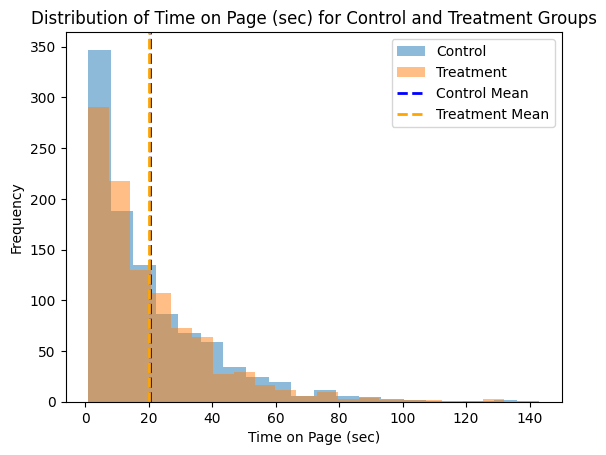

In [26]:
import matplotlib.pyplot as plt

# Plot histograms for control and treatment groups
plt.hist(control_group['Time on Page (sec)'], bins=20, alpha=0.5, label='Control')
plt.hist(treatment_group['Time on Page (sec)'], bins=20, alpha=0.5, label='Treatment')

# Add a line graph for mean
plt.axvline(control_group['Time on Page (sec)'].mean(), color='blue', linestyle='dashed', linewidth=2, label='Control Mean')
plt.axvline(treatment_group['Time on Page (sec)'].mean(), color='orange', linestyle='dashed', linewidth=2, label='Treatment Mean')

plt.xlabel('Time on Page (sec)')
plt.ylabel('Frequency')
plt.title('Distribution of Time on Page (sec) for Control and Treatment Groups')

plt.legend()

plt.show()

# **5. GMV (in $)**

In [27]:
# 5. GMV (in $)

# Check the mean GMV on page by group
data.groupby('Variant')['GMV (in $)'].agg(["count", "median", "mean", "std", "min", "max"])

,count,median,mean,std,min,max
Variant,,,,,,
A,1000,0.0,7.68999,26.794816,0.0,152.61
B,1000,0.0,9.28953,28.879687,0.0,141.27


<ipython-input-28-daf9c76b9a7b>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data, x='GMV (in $)', y='Variant', inner='box', palette='Set2')


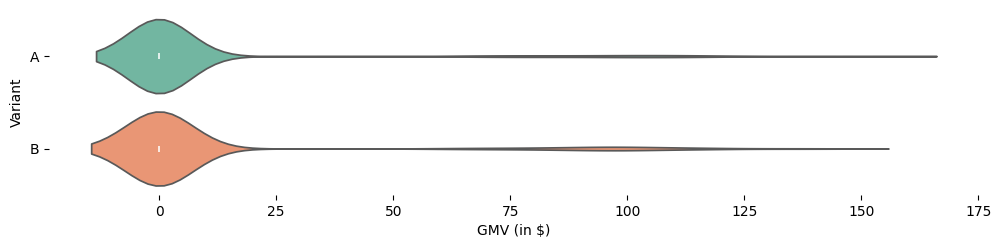

In [28]:
figsize = (12, 1.2 * len(data['Variant'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(data, x='GMV (in $)', y='Variant', inner='box', palette='Set2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [29]:
# Assuming 'Variant' column contains control and treatment groups
control_group = data[data['Variant'] == 'A']
treatment_group = data[data['Variant'] == 'B']

# Calculate the mean GMV for both groups
mean_gmv_control = control_group['GMV (in $)'].mean()
mean_gmv_treatment = treatment_group['GMV (in $)'].mean()

# Calculate the difference in mean GMV
mean_gmv_difference = mean_gmv_treatment - mean_gmv_control

# Perform a two-sample t-test
t_stat, p_value = ttest_ind(control_group['GMV (in $)'], treatment_group['GMV (in $)'], equal_var=False, nan_policy='omit')

# Assume a significance level
alpha = 0.05

# Print results
print(f"Mean GMV (Control): {mean_gmv_control}")
print(f"Mean GMV (Treatment): {mean_gmv_treatment}")
print(f"Difference in Mean GMV: {mean_gmv_difference}")
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

if p_value < alpha:
    print("Null hypothesis rejected. There is a statistically significant difference between groups.")
else:
    print("Null hypothesis not rejected. There is no statistically significant difference between groups.")

Mean GMV (Control): 7.689989999999999
Mean GMV (Treatment): 9.28953
Difference in Mean GMV: 1.5995400000000002
T-statistic: -1.2839539769831623
P-value: 0.19930776178517312
Null hypothesis not rejected. There is no statistically significant difference between groups.


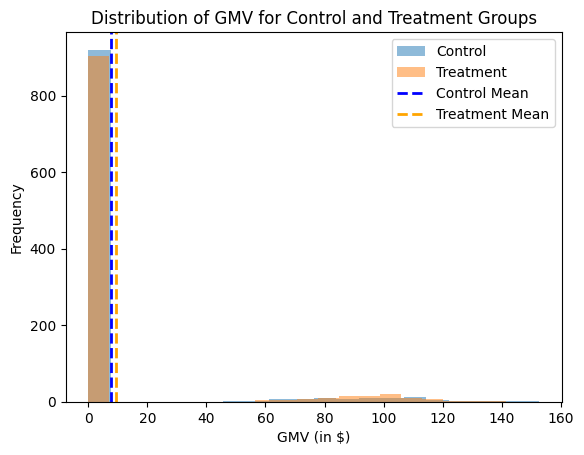

In [30]:
import matplotlib.pyplot as plt

# Plot histograms for control and treatment groups
plt.hist(control_group['GMV (in $)'], bins=20, alpha=0.5, label='Control')
plt.hist(treatment_group['GMV (in $)'], bins=20, alpha=0.5, label='Treatment')

# Add a line graph for mean
plt.axvline(control_group['GMV (in $)'].mean(), color='blue', linestyle='dashed', linewidth=2, label='Control Mean')
plt.axvline(treatment_group['GMV (in $)'].mean(), color='orange', linestyle='dashed', linewidth=2, label='Treatment Mean')

plt.xlabel('GMV (in $)')
plt.ylabel('Frequency')
plt.title('Distribution of GMV for Control and Treatment Groups')

plt.legend()

plt.show()

# **6. Conversion Rate**

In [31]:
# Assuming 'Variant' column contains control and treatment groups
control_group = data[data['Variant'] == 'A']
treatment_group = data[data['Variant'] == 'B']

# Define the conversion rate
def conversion_rate(data):
    return data['Number of add to cart'].sum() / data['Number of page views'].sum()

# Calculate the conversion rate for both groups
conversion_rate_control = conversion_rate(control_group)
conversion_rate_treatment = conversion_rate(treatment_group)

# Perform a two-sample t-test
t_stat, p_value = ttest_ind(control_group['Number of add to cart'], treatment_group['Number of add to cart'])

# Assume a significance level
alpha = 0.05

# Print results
print(f"Conversion Rate (Control): {conversion_rate_control}")
print(f"Conversion Rate (Treatment): {conversion_rate_treatment}")
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

if p_value < alpha:
    print("Null hypothesis rejected. There is a statistically significant difference between groups.")
else:
    print("Null hypothesis not rejected. There is no statistically significant difference between groups.")

Conversion Rate (Control): 0.3779338014042126
Conversion Rate (Treatment): 0.4643596012789167
T-statistic: -8.777389396187946
P-value: 3.517078745065221e-18
Null hypothesis rejected. There is a statistically significant difference between groups.


In [32]:
from statsmodels.stats.proportion import proportions_ztest

# Assuming 'Variant' column contains control and treatment groups
control_group = data[data['Variant'] == 'A']
treatment_group = data[data['Variant'] == 'B']

# Define the conversion rate
def conversion_rate(data):
    return data['Number of add to cart'].sum() / data['Number of page views'].sum()

# Calculate the conversion rate for both groups
conversion_rate_control = conversion_rate(control_group)
conversion_rate_treatment = conversion_rate(treatment_group)

# Number of successes (add to cart) and number of trials (page views) for each group
successes_control = control_group['Number of add to cart'].sum()
trials_control = control_group['Number of page views'].sum()
successes_treatment = treatment_group['Number of add to cart'].sum()
trials_treatment = treatment_group['Number of page views'].sum()

# Perform a two-sample z-test
z_stat, p_value = proportions_ztest([successes_control, successes_treatment], [trials_control, trials_treatment])

# Assume a significance level
alpha = 0.05

# Print results
print(f"Conversion Rate (Control): {conversion_rate_control}")
print(f"Conversion Rate (Treatment): {conversion_rate_treatment}")
print(f"Z-statistic: {z_stat}")
print(f"P-value: {p_value}")

if p_value < alpha:
    print("Null hypothesis rejected. There is a statistically significant difference between groups.")
else:
    print("Null hypothesis not rejected. There is no statistically significant difference between groups.")

Conversion Rate (Control): 0.3779338014042126
Conversion Rate (Treatment): 0.4643596012789167
Z-statistic: -8.874701895488451
P-value: 7.012097606206308e-19
Null hypothesis rejected. There is a statistically significant difference between groups.


In [33]:
# Assuming 'Variant' column contains control and treatment groups
control_group = data[data['Variant'] == 'A']
treatment_group = data[data['Variant'] == 'B']

# Define the conversion rate
def conversion_rate(data):
    return data['GMV (in $)'].sum() / data['Number of page views'].sum()

# Calculate the conversion rate for both groups
conversion_rate_control = conversion_rate(control_group)
conversion_rate_treatment = conversion_rate(treatment_group)

# Perform a two-sample t-test
t_stat, p_value = ttest_ind(control_group['GMV (in $)'], treatment_group['GMV (in $)'])

# Assume a significance level
alpha = 0.05

# Print results
print(f"Conversion Rate (Control): {conversion_rate_control}")
print(f"Conversion Rate (Treatment): {conversion_rate_treatment}")
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

if p_value < alpha:
    print("Null hypothesis rejected. There is a statistically significant difference between groups.")
else:
    print("Null hypothesis not rejected. There is no statistically significant difference between groups.")

Conversion Rate (Control): 1.5426258776328985
Conversion Rate (Treatment): 1.7471374835433513
T-statistic: -1.2839539769831623
P-value: 0.19930692918202245
Null hypothesis not rejected. There is no statistically significant difference between groups.


In [35]:
# Assuming 'Variant' column contains control and treatment groups
control_group = data[data['Variant'] == 'A']
treatment_group = data[data['Variant'] == 'B']

# Define the conversion rate
def conversion_rate(data):
    return data['GMV (in $)'].sum() / data['Number of page views'].sum()

# Calculate the conversion rate for both groups
conversion_rate_control = conversion_rate(control_group)
conversion_rate_treatment = conversion_rate(treatment_group)

# Number of successes (add to cart) and number of trials (page views) for each group
successes_control = control_group['GMV (in $)'].sum()
trials_control = control_group['Number of page views'].sum()
successes_treatment = treatment_group['GMV (in $)'].sum()
trials_treatment = treatment_group['Number of page views'].sum()

# Perform a two-sample z-test
z_stat, p_value = proportions_ztest([successes_control, successes_treatment], [trials_control, trials_treatment])

# Assume a significance level
alpha = 0.05

# Print results
print(f"Conversion Rate (Control): {conversion_rate_control}")
print(f"Conversion Rate (Treatment): {conversion_rate_treatment}")
print(f"Z-statistic: {z_stat}")
print(f"P-value: {p_value}")

if p_value < alpha:
    print("Null hypothesis rejected. There is a statistically significant difference between groups.")
else:
    print("Null hypothesis not rejected. There is no statistically significant difference between groups.")

Conversion Rate (Control): 1.5426258776328985
Conversion Rate (Treatment): 1.7471374835433513
Z-statistic: nan
P-value: nan
Null hypothesis not rejected. There is no statistically significant difference between groups.


/usr/local/lib/python3.10/dist-packages/statsmodels/stats/proportion.py:1025: RuntimeWarning: invalid value encountered in sqrt
  std_diff = np.sqrt(var_)


In [34]:
# Assuming 'Variant' column contains control and treatment groups
control_group = data[data['Variant'] == 'A']
treatment_group = data[data['Variant'] == 'B']

# Define the conversion rate
def conversion_rate(data):
    return data['GMV (in $)'].sum() / data['Number of add to cart'].sum()

# Calculate the conversion rate for both groups
conversion_rate_control = conversion_rate(control_group)
conversion_rate_treatment = conversion_rate(treatment_group)

# Perform a two-sample t-test
t_stat, p_value = ttest_ind(control_group['GMV (in $)'], treatment_group['GMV (in $)'])

# Assume a significance level
alpha = 0.05

# Print results
print(f"Conversion Rate (Control): {conversion_rate_control}")
print(f"Conversion Rate (Treatment): {conversion_rate_treatment}")
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

if p_value < alpha:
    print("Null hypothesis rejected. There is a statistically significant difference between groups.")
else:
    print("Null hypothesis not rejected. There is no statistically significant difference between groups.")

Conversion Rate (Control): 4.0817356687898085
Conversion Rate (Treatment): 3.762466585662211
T-statistic: -1.2839539769831623
P-value: 0.19930692918202245
Null hypothesis not rejected. There is no statistically significant difference between groups.


In [36]:
# Assuming 'Variant' column contains control and treatment groups
control_group = data[data['Variant'] == 'A']
treatment_group = data[data['Variant'] == 'B']

# Define the conversion rate
def conversion_rate(data):
    return data['GMV (in $)'].sum() / data['Number of add to cart'].sum()

# Calculate the conversion rate for both groups
conversion_rate_control = conversion_rate(control_group)
conversion_rate_treatment = conversion_rate(treatment_group)

# Number of successes (add to cart) and number of trials (page views) for each group
successes_control = control_group['GMV (in $)'].sum()
trials_control = control_group['Number of add to cart'].sum()
successes_treatment = treatment_group['GMV (in $)'].sum()
trials_treatment = treatment_group['Number of add to cart'].sum()

# Perform a two-sample z-test
z_stat, p_value = proportions_ztest([successes_control, successes_treatment], [trials_control, trials_treatment])

# Assume a significance level
alpha = 0.05

# Print results
print(f"Conversion Rate (Control): {conversion_rate_control}")
print(f"Conversion Rate (Treatment): {conversion_rate_treatment}")
print(f"Z-statistic: {z_stat}")
print(f"P-value: {p_value}")

if p_value < alpha:
    print("Null hypothesis rejected. There is a statistically significant difference between groups.")
else:
    print("Null hypothesis not rejected. There is no statistically significant difference between groups.")

Conversion Rate (Control): 4.0817356687898085
Conversion Rate (Treatment): 3.762466585662211
Z-statistic: nan
P-value: nan
Null hypothesis not rejected. There is no statistically significant difference between groups.
